In [1]:
import re
import glob

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score


In [25]:
test_df = pd.read_csv('1. data/final/test.csv')
true_labels = test_df['Label']

def build_roc_curve(predictions, title, name, include_baseline=True, columns_to_plot=None):
        plt.figure(figsize=(10, 8))
        # Liste für die Speicherung der Vorhersagen und AUC-Scores
        rocs = []

        for prediction in predictions:
            # Extrahieren Sie den relevanten Teil des Strings
            relevant_part = re.search(r'predictions/(.*)_predictions.csv', prediction).group(1)

            # Teilen Sie den relevanten Teil des Strings in Unterstrings
            substrings = relevant_part.split('_')
            model_name = substrings[0]
            boolean = substrings[1]
            if boolean == 'True':
                adapter = 'Adapter'
            else:
                adapter = 'Model'
            column_name = substrings[2]
            adapter_config = substrings[3]
            date = substrings[4]
            # Create the filename pattern based on the adapter_config_name
            predictions_df = pd.read_csv(f'{prediction}')
            auc_score = roc_auc_score(true_labels, predictions_df.iloc[:, 1])
            fpr, tpr, _ = roc_curve(true_labels, predictions_df.iloc[:, 1])
            # Add AUC-Score 
            rocs.append((fpr, tpr, auc_score, model_name, adapter_config, column_name, adapter))        
        # Sort by AUC-Score
        rocs.sort(key=lambda x: x[2], reverse=True)

        # viridis-Farbskala
        cmap = plt.cm.get_cmap('viridis')

        # Plots
        if include_baseline:
            single_predictions_df = pd.read_csv('2. models/predictions/single_input_predictions_benchmark.csv')
            multiple_predictions_df = pd.read_csv('2. models/predictions/multiple_input_predictions_benchmark.csv')
            for i, (fpr, tpr, auc_score, model_name, adapter_config, column_name, adapter) in enumerate(rocs):
                label = ', '.join([value for name, value in zip(['model_name', 'adapter_config', 'column_name', 'adapter'], [model_name, adapter_config, column_name, adapter]) if name in columns_to_plot])
                plt.plot(fpr, tpr, color=cmap(i / (len(rocs)+2)), label=f'{label} (AUC: {auc_score:.2f})')
            auc_score = roc_auc_score(true_labels, single_predictions_df.iloc[:, 1])
            fpr, tpr, _ = roc_curve(true_labels, single_predictions_df.iloc[:, 1])
            plt.plot(fpr, tpr, color=cmap((len(rocs)+1) / (len(rocs)+2)),label=f'Benchmark (Analyst Prediction) (AUC: {auc_score:.2f})')
            auc_score = roc_auc_score(true_labels, multiple_predictions_df.iloc[:, 1])
            fpr, tpr, _ = roc_curve(true_labels, multiple_predictions_df.iloc[:, 1])
            plt.plot(fpr, tpr, color=cmap((len(rocs)+2) / (len(rocs)+2)), label=f'Benchmark (XGBoost) (AUC: {auc_score:.2f})')
        else:
            for i, (fpr, tpr, auc_score, model_name, adapter_config, column_name, adapter) in enumerate(rocs):
                label = ', '.join([value for name, value in zip(['model_name', 'adapter_config', 'column_name', 'adapter'], [model_name, adapter_config, column_name, adapter]) if name in columns_to_plot])
                plt.plot(fpr, tpr, color=cmap(i / len(rocs)), label=f'{label} (AUC: {auc_score:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Specificity')
        plt.ylabel('Sensitivity')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.savefig(f'3. evaluation/roc_curves/{name}.png')
        

In [26]:
top_models = pd.read_csv('3. evaluation/auc_scores/auc_scores.csv')
# sort by "date" and only where LoRAConfig is in adapter_config column and adapter is True and column_name is 'AnalystNoteList'

top_models = top_models[top_models['adapter'] == True]
top_models = top_models[top_models['column_name'] == 'AnalystNoteList']
top_models = top_models[top_models['adapter_config'].str.contains('LoRAConfig')]
top_models = top_models.sort_values(by='date', ascending=False)
top_models.reset_index(drop=True, inplace=True)
top_models


,model_name,adapter,adapter_config,column_name,auc_score,date
0,distilbert/distilbert-base-uncased-finetuned-s...,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.571641,2024-04-23
1,soleimanian/financial-roberta-large-sentiment,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.554292,2024-04-23
2,ahmedrachid/FinancialBERT-Sentiment-Analysis,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.517716,2024-04-23
3,RashidNLP/Finance-Sentiment-Classification,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.516431,2024-04-23
4,siebert/sentiment-roberta-large-english,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.513328,2024-04-23
5,ProsusAI/finbert,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.495163,2024-04-23
6,kwang123/bert-sentiment-analysis,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.490366,2024-04-23
7,yiyanghkust/finbert-tone,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.590970,2024-04-22
8,nickmuchi/sec-bert-finetuned-finance-classific...,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.581990,2024-04-22
9,nickmuchi/deberta-v3-base-finetuned-finance-te...,True,"LoRAConfig(architecture='lora', selfattn_lora=...",AnalystNoteList,0.541699,2024-04-22


In [27]:

# Patterns
pattern1 = "2. models/predictions/*_True_AnalystNoteList_LoRAConfig_2024-04-2*_predictions.csv"

# Find patterns
filenames = glob.glob(pattern1)

# Print
for filename in filenames:
    print(filename)

2. models/predictions/kwang123-bert-sentiment-analysis_True_AnalystNoteList_LoRAConfig_2024-04-23_predictions.csv
2. models/predictions/nickmuchi-deberta-v3-base-finetuned-finance-text-classification_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/yiyanghkust-finbert-tone_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/bardsai-finance-sentiment-pl-fast_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/RashidNLP-Finance-Sentiment-Classification_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/soleimanian-financial-roberta-large-sentiment_True_AnalystNoteList_LoRAConfig_2024-04-23_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/ahmedrachid-FinancialBERT-Sentiment-Analysis_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/

/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_88002/348153787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


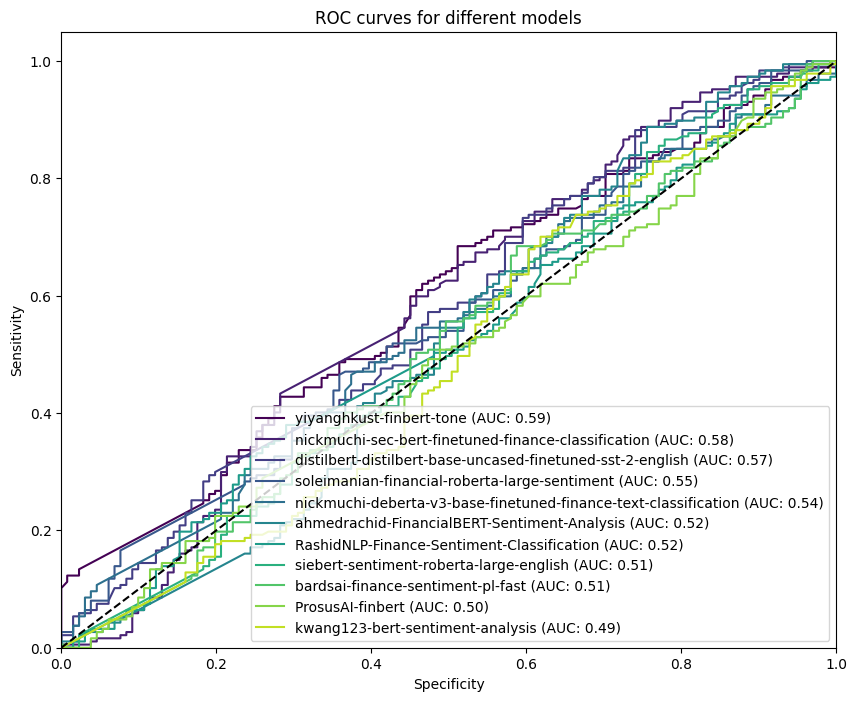

In [28]:
build_roc_curve(filenames, 'ROC curves for different models', 'First Experiment', include_baseline=False, columns_to_plot=['model_name'])

In [29]:
top_models = pd.read_csv('3. evaluation/auc_scores/auc_scores.csv')
# sort by "date" and only where LoRAConfig is in adapter_config column and adapter is True and column_name is 'AnalystNoteList'

top_models = top_models[top_models['adapter'] == True]
top_models = top_models[top_models['column_name'] == 'AnalystNoteList']
top_models = top_models[~top_models['adapter_config'].str.contains('LoRAConfig')]
top_models = top_models.sort_values(by='date', ascending=False)
top_models.reset_index(drop=True, inplace=True)
top_models


,model_name,adapter,adapter_config,column_name,auc_score,date
0,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,AnalystNoteList,0.709413,2024-04-25
1,yiyanghkust/finbert-tone,True,<adapters.configuration.adapter_config.MAMConf...,AnalystNoteList,0.708372,2024-04-25
2,yiyanghkust/finbert-tone,True,<adapters.configuration.adapter_config.ConfigU...,AnalystNoteList,0.655264,2024-04-25
3,yiyanghkust/finbert-tone,True,<adapters.configuration.adapter_config.UniPELT...,AnalystNoteList,0.649284,2024-04-25
4,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.UniPELT...,AnalystNoteList,0.586439,2024-04-25
5,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.ConfigU...,AnalystNoteList,0.586439,2024-04-25


In [30]:

# Patterns
pattern1 = "2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_AnalystNoteList_*_2024-04-2*_predictions.csv"
pattern2 = "2. models/predictions/yiyanghkust-finbert-tone_True_AnalystNoteList_*_2024-04-2*_predictions.csv"
# Find patterns
filenames = glob.glob(pattern1) + glob.glob(pattern2)

# Print
for filename in filenames:
    print(filename)

2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_AnalystNoteList_ConfigUnion_2024-04-23_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_AnalystNoteList_UniPELTConfig_2024-04-23_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_AnalystNoteList_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/yiyanghkust-finbert-tone_True_AnalystNoteList_LoRAConfig_2024-04-22_predictions.csv
2. models/predictions/yiyanghkust-finbert-tone_True_AnalystNoteList_ConfigUnion_2024-04-25_predictions.csv
2. models/predictions/yiyanghkust-finbert-tone_True_AnalystNoteList_UniPELTConfig_2024-04-25_predictions.csv
2. models/predictions/yiyanghkust-finbert-tone_True_AnalystNoteList_MAMConfig_2024-04-25_predictions.csv


/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_88002/348153787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


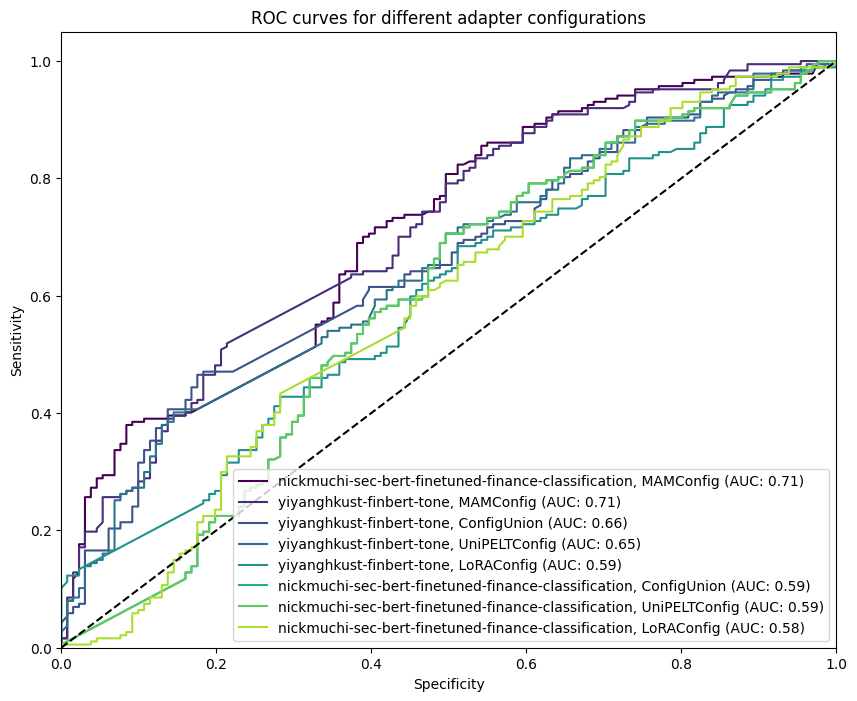

In [31]:
build_roc_curve(filenames, 'ROC curves for different adapter configurations', 'Second Experiment', include_baseline=False, columns_to_plot=['model_name', 'adapter_config'])

In [32]:
top_models = pd.read_csv('3. evaluation/auc_scores/auc_scores.csv')
# sort by "date" and only where LoRAConfig is in adapter_config column and adapter is True and column_name is 'AnalystNoteList'

top_models = top_models[top_models['adapter'] == True]
top_models = top_models[top_models['model_name'].str.contains('nickmuchi')]
top_models = top_models[top_models['adapter_config'].str.contains('MAMConfig')]
top_models = top_models.sort_values(by='date', ascending=False)
# Drop duplicates based on specific columns and keep the first occurrence
top_models = top_models.drop_duplicates(subset=['model_name', 'adapter', 'column_name'], keep='first')
top_models.reset_index(drop=True, inplace=True)
top_models


,model_name,adapter,adapter_config,column_name,auc_score,date
0,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,FinancialStrengthText,0.743438,2024-04-30
1,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,RiskAnalysis,0.738825,2024-04-25
2,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,Profile,0.727314,2024-04-25
3,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,ResearchThesisList,0.725150,2024-04-25
4,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,BullsList,0.721925,2024-04-25
5,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,MoatAnalysis,0.718782,2024-04-25
6,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,BearsList,0.718700,2024-04-25
7,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,AnalystNoteList,0.709413,2024-04-25
8,nickmuchi/sec-bert-finetuned-finance-classific...,True,<adapters.configuration.adapter_config.MAMConf...,CapitalAllocation,0.704780,2024-04-25


In [33]:
# Patterns
pattern1 = "2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_*_MAMConfig_2024-04-*_predictions.csv"

# Find patterns
filenames = glob.glob(pattern1)
# Print
for filename in filenames:
    print(filename)

2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_FinancialStrengthText_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_BearsList_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_Profile_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_ResearchThesisList_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_CapitalAllocation_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_MoatAnalysis_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_RiskAnalysis_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_Analys

/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_88002/348153787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


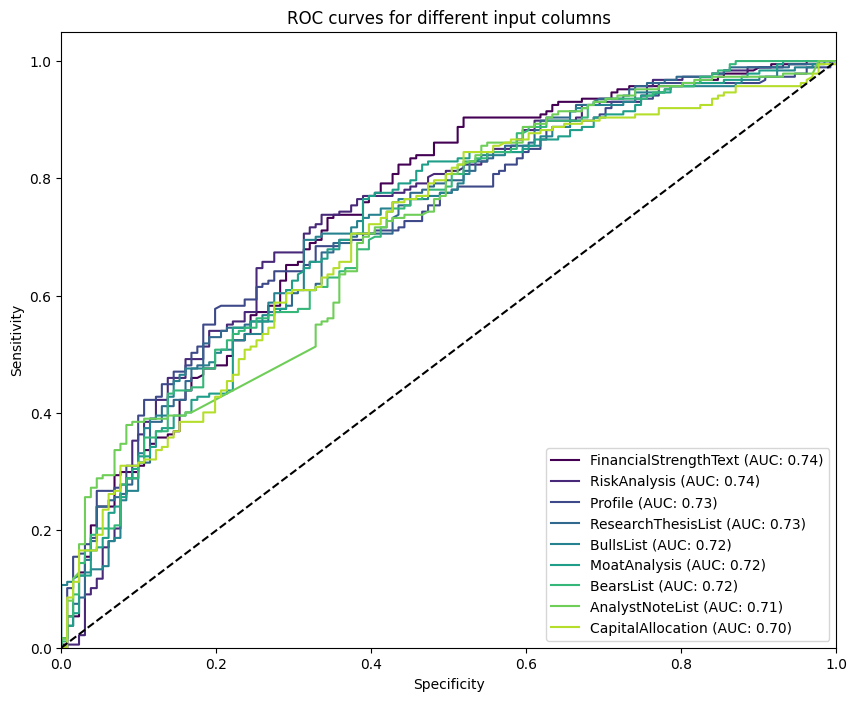

In [34]:
build_roc_curve(filenames, 'ROC curves for different input columns', 'Third Experiment', include_baseline=False, columns_to_plot=['column_name'])

In [35]:
# Patterns
pattern1 = "2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_FinancialStrengthText_MAMConfig_2024-04-25_predictions.csv"
pattern2 = "2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_False_FinancialStrengthText_MAMConfig_2024-04-30_predictions.csv"
# Find patterns
filenames = glob.glob(pattern1)+ glob.glob(pattern2)

# Print
for filename in filenames:
    print(filename)

2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_True_FinancialStrengthText_MAMConfig_2024-04-25_predictions.csv
2. models/predictions/nickmuchi-sec-bert-finetuned-finance-classification_False_FinancialStrengthText_MAMConfig_2024-04-30_predictions.csv


/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_88002/348153787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


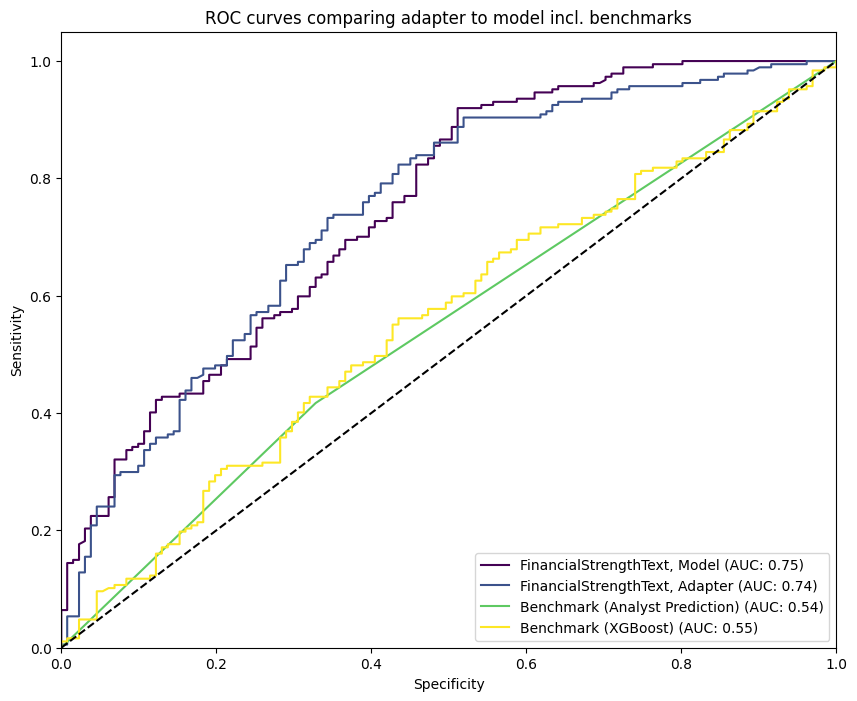

In [36]:
build_roc_curve(filenames, 'ROC curves comparing adapter to model incl. benchmarks', 'Fourth Experiment', include_baseline=True, columns_to_plot=['adapter', 'column_name',])

/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_88002/348153787.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


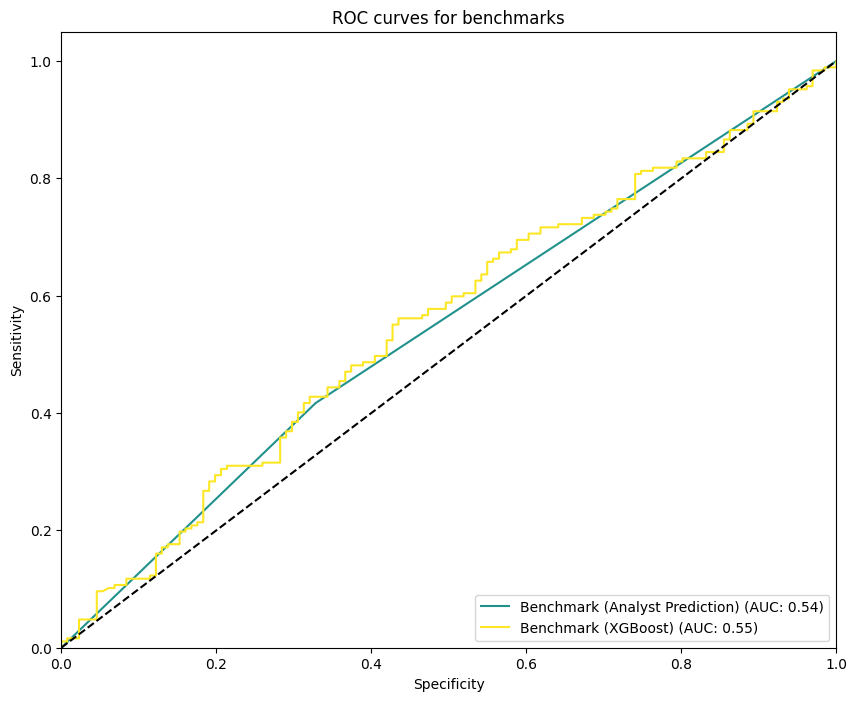

In [37]:
build_roc_curve([], 'ROC curves for benchmarks', 'Zero Experiment', include_baseline=True, columns_to_plot=[])